In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

Text(0, 0.5, 'angle correlation')

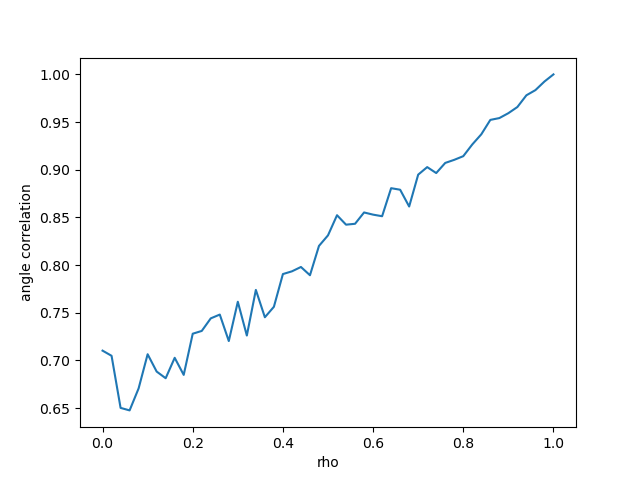

In [4]:
n_syns = 1000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

conf = configs.sac_mode_config()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
rng = np.random.default_rng()
dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
thetas = {}
corrs = []

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    ts = np.zeros((np.sum(sac_net.gaba_here), 2))
    ts[:, 0] = sac_net.thetas["E"][sac_net.gaba_here]
    ts[:, 1] = sac_net.thetas["I"][sac_net.gaba_here]
    thetas[rho] = ts
    corrs.append(circcorrcoef(np.radians(ts[:, 0]), np.radians(ts[:, 1])))

corrs = np.array(corrs)

real_corr_fig, real_corr_ax = plt.subplots(1)
real_corr_ax.plot(rhos, corrs)
real_corr_ax.set_xlabel("rho")
real_corr_ax.set_ylabel("angle correlation")

In [16]:
project_onto_line(np.array([-10, -10]), np.array([10, 10]), np.array([5, 0]))

array([2.5, 2.5])

In [21]:
rotate([0, 0], 5, 5, np.radians(-45))

(7.0710678118654755, 4.440892098500626e-16)